# Welcome to Fondation!

**Fondation** is a framework for time series forecasting and missing value imputation. So far we only support data from INSEE, but hang in there..

## Installation
The following steps will guide you through the installation of **Fondation**.

1. Setup the environment
Run the following in your terminal:
```bash
pip install virtualenv
virtualenv fondation
source fondation/bin/activate
pip install -r requirements.txt
```

2. Create a dotenv file
```bash
touch .env
```

3. Download the INSEE data
This step can take a while so be patient. Run the following in your terminal:
```bash
python -m scripts.data_fetching.create_insee_tables
```
---

## Explore the data

The entry point to the data is the `DataProcessor` class, you can use it to load and transform the data for oracle to use.

The DataProcessor registers a chain of `Processors` and fits them sequentially on the data. It will automatically transform and inverse transform the data for you.
Here's an example to guide you..



### Create, fit, save and load the DataProcessor

In [150]:
from datetime import datetime
import matplotlib.pyplot as plt
from src.dl_framework.data_pipeline.scalers.trend_scaler import TrendRemovalConfig
from src.dl_framework.core.models.insee_econ_model import InseeEconModel
from src.dl_framework.data_pipeline.data_processor import DataProcessor
from src.dl_framework.data_pipeline.data_states.insee_data_state import InseeDataState
from src.data_sources.data_source import DataSource
from src.logging_config import setup_logging

setup_logging()

In [2]:
# Instantiate a DataProcessor object with specified bounds and train cutoff for fitting the data.
data_processor = DataProcessor(
    DataSource.INSEE,
    min_date=datetime(1970, 1, 1),
    max_date=datetime(2017, 1, 1),
    train_cutoff=datetime(2016, 1, 1))

# Trend removal requires a configuration, here's one that gives decent results
config = TrendRemovalConfig(
    exponential_mse_scale=0.21, # The lower the value, the more exponential will be favoured.
    inverse_exponential_mse_scale=0.64 # The lower the value, the more negative exponential will be favoured.
)

# Register the processors to the DataProcessor object. You may combine them in any shape and form
data_processor = data_processor.add_range_scaler() # Add a range scaler for normalization
data_processor = data_processor.add_trend_removal(config, processor_id='trend') # Add a trend removal processor and give it an id
data_processor = data_processor.add_scaler() # Add a StandardScaler for normalization

# Fit it on the data from the data source.
data_processor.fit_from_provider()

# Save the DataProcessor object for later use.
data_processor.save("my_processor.pkl")

2025-01-28 00:10:26,577 - DataProcessor - INFO - Finished fitting processors for table CHOMAGE-TRIM-NATIONAL
2025-01-28 00:10:26,834 - DataProcessor - INFO - Finished fitting processors for table CLIMAT-AFFAIRES
2025-01-28 00:10:37,536 - DataProcessor - INFO - Finished fitting processors for table CNA-2020-CONSO-MEN
2025-01-28 00:10:41,234 - DataProcessor - INFO - Finished fitting processors for table CNA-2020-CONSO-SI
2025-01-28 00:10:45,113 - DataProcessor - INFO - Finished fitting processors for table CNA-2020-CPEB
2025-01-28 00:10:45,132 - DataProcessor - INFO - Finished fitting processors for table CNA-2020-CSI
2025-01-28 00:10:48,448 - DataProcessor - INFO - Finished fitting processors for table CNA-2020-EMPLOI
2025-01-28 00:10:58,361 - DataProcessor - INFO - Finished fitting processors for table CNA-2020-ERE
2025-01-28 00:10:59,025 - DataProcessor - INFO - Finished fitting processors for table CNA-2020-FBCF-SI
2025-01-28 00:10:59,296 - DataProcessor - INFO - Finished fitting pro

In [152]:
# Let's see if we can load it directly even if we delete the data_processor variable
del data_processor

data_processor = DataProcessor.load("my_processor.pkl")
print("Min date from saved processor:", data_processor.train_cutoff)

Min date from saved processor: 2016-01-01 00:00:00


### Transform and visualize the data

In [153]:
import random
from src.dl_framework.data_pipeline.data_utils import DataUtils

In [154]:
# We can transform the data by iterating over the DataProcessor's transform_from_provider method.
all_states = [state for state in data_processor.transform_from_provider()]
print(f"Transformed {len(all_states)} tables")
print(f"First 3 table names: {[state.table_name for state in all_states[:3]]}")

2025-01-28 01:44:11,694 - DataProvider - INFO - Streamed 39 elements from INSEE
Transformed 39 tables
First 3 table names: ['CHOMAGE-TRIM-NATIONAL', 'CLIMAT-AFFAIRES', 'CNA-2020-CONSO-MEN']


Table name: NAISSANCES-FECONDITE 
Column name: Indicateur conjoncturel de fécondité des femmes de 25 à 34 ans - Gironde


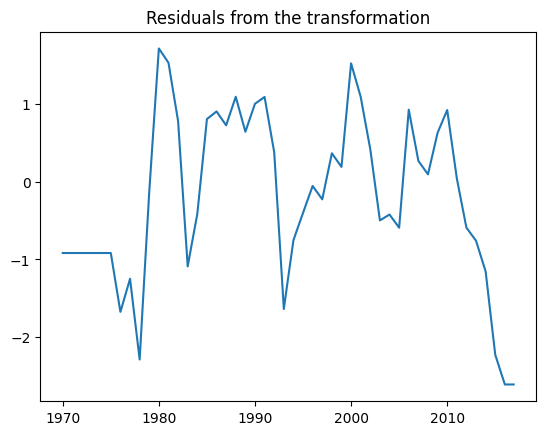

In [156]:
# Let's visualize the data
sample_state = all_states[random.randint(0, len(all_states))]
table_name     = sample_state.table_name
dates          = sample_state.dates
data           = sample_state.data
column_to_name = sample_state.col_to_name

interpolated_data = DataUtils.interpolate_missing_values(data.copy())
sample_column = random.randint(0, data.shape[1])

print(f"Table name: {table_name} \nColumn name: {column_to_name[sample_column]}")
plt.plot(dates, interpolated_data[:, sample_column])
plt.title("Residuals from the transformation")
plt.show()

<div class="alert alert-block alert-success">
<b>Tip:</b> You should notice in the above chart if the data has been scaled correctly, that the mean is around 0 and the variance is around 1. If you see a trend in the data, then the trend removal processor has not been applied correctly.
</div>


2025-01-28 00:29:29,957 - DataProcessor - INFO - Obtaining trends data...
2025-01-28 00:29:30,008 - DataProcessor - INFO - Obtaining raw data...


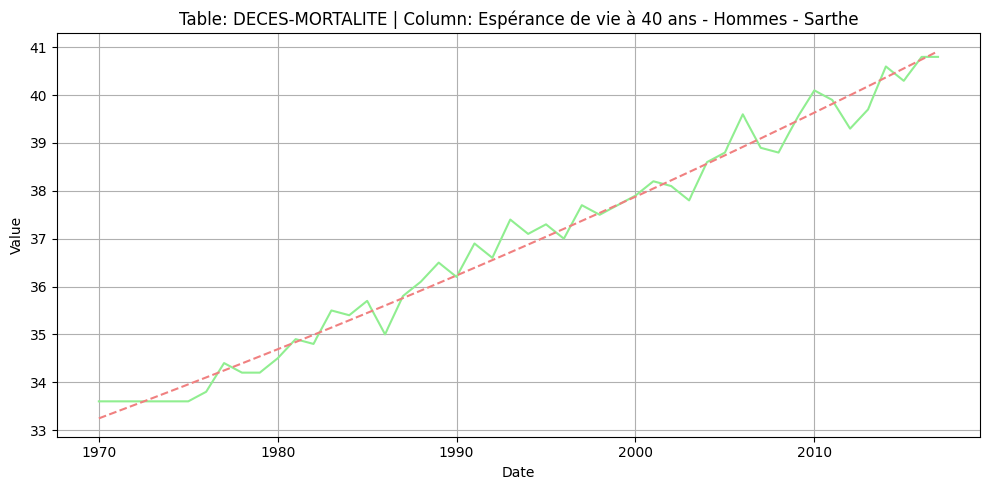

In [20]:
# Visualize the trend that was used to fit this data
data_processor.plot_trends(processor_id="trend", table_name=table_name, columns=[sample_column], show=True)

<div class="alert alert-block alert-success">
<b>If it looks good:</b> Congratulation! You found a good configuration for the trend removal processor.
</div>
<div class="alert alert-block alert-danger">
<b>If it doesn't:</b> Well we still have work to do on our side :(
</div>

You can use the following snippet to visualize only a certain time period of the trend.
```python
data_processor.plot_trends(processor_id="trend", table_name=table_name, columns=[sample_column], show=True, min_date=datetime(2010, 1, 1), max_date=datetime(2017, 1, 1))
```


## Make and use a super cool model to predict the future
Currently training is tied to the Weights and Biases platform, so you can't train the model locally. But rest assured, we have a model ready to predict the downfall for you!

In [141]:
import torch
import numpy as np
from src.dl_framework.data_pipeline.datasets.insee_collator import econ_collate_fn
from src.dl_framework.data_pipeline.datasets.insee_dataset import InseeDataset

In [142]:
data_processor = DataProcessor.load("models/deft-sweep-2/data_processor.pkl")

model_config = {
    "embed_dim": 96,
    "n_heads": 4,
    "num_layers": 3,
    "pool_heads": 4,
    "use_pos_encoding": True,
}

model = InseeEconModel(
    table_names=data_processor.table_names,
    table_shapes=[state.data.shape[1] for state in all_states],
    **model_config
)

# Load the best model from the local save
status = model.load_state_dict(torch.load("models/deft-sweep-2/best_model.pth", weights_only=True), strict=False)
_ = model.eval()

print(status)

Created 2D positional encoding with shape: torch.Size([1, 5000, 1, 96])
<All keys matched successfully>


In [143]:
# Create the dataset object

test_dataset = InseeDataset(
    data_processor,
    min_window_length_year=10,
    max_window_length_year=10,
    number_of_samples=1,
    seed=42,
    inference_mode=True # This will use train data and mask the test data
)

model_input = econ_collate_fn([test_dataset[0]])
print("Model input structure:")
print(model_input.keys())

2025-01-28 01:39:42,558 - DataProvider - INFO - Streamed 39 elements from INSEE
Model input structure:
dict_keys(['full_data', 'mask', 'padding_mask'])


In [144]:
# Make the prediction
with torch.no_grad():
    prediction = model(model_input)

print("Prediction structure:")
print(prediction.keys())

Prediction structure:
dict_keys(['CHOMAGE-TRIM-NATIONAL', 'CLIMAT-AFFAIRES', 'CNA-2020-CONSO-MEN', 'CNA-2020-CONSO-SI', 'CNA-2020-CPEB', 'CNA-2020-CSI', 'CNA-2020-EMPLOI', 'CNA-2020-ERE', 'CNA-2020-FBCF-SI', 'CNA-2020-PIB', 'CNA-2020-TEI', 'CNT-2020-CB', 'CNT-2020-CSI', 'CNT-2020-OPERATIONS', 'CNT-2020-PIB-EQB-RF', 'CONSO-MENAGES-2020', 'DECES-MORTALITE', 'DEFAILLANCES-ENTREPRISES', 'EMPLOI-SALARIE-TRIM-NATIONAL', 'ENQ-CONJ-ACT-IND', 'ENQ-CONJ-IND-BAT', 'ENQ-CONJ-MENAGES', 'ENQ-CONJ-SERV', 'ENQ-CONJ-TP', 'INDICES_LOYERS', 'IP-PROD-CONS-N-HAB-2021', 'IPI-2021', 'IPPI-2021', 'IPPMP-NF', 'NAISSANCES-FECONDITE', 'PARC-LOGEMENTS', 'POPULATION-STRUCTURE', 'SALAIRES-ANNUELS', 'SMIC-COTISATIONS', 'TAUX-CHOMAGE', 'TCRED-EMPLOI-31-DECEMBRE-BASE-2018', 'TCRED-ESTIMATIONS-POPULATION', 'TCRED-TRAVAIL-EMPLOI-TCHOMA-SA', 'TRANSPORTS'])


In [145]:
# Get the date for which we have made a prediction:
train_cutoff = test_dataset.test_start_idx
dates = data_processor.date_range[train_cutoff:]
print(dates)

['2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01']


In [146]:
# In reality, the prediction is only made for values that are reported, therefore yearly values can be problematic. Hence we will only take 2016-2017 and visualize the GDP
# Let's inverse transform our prediction and the real data to visualize them
# In order to do that, we need to wrap them in an InseeDataState object, for simplicity let's copy the one from our DataProcessor and replace the data with our mode prediction

table_name = "CNA-2020-PIB" # Try using "TAUX-CHOMAGE" or "CNA-2020-PIB"
column_id = 13

all_states = [state for state in data_processor.transform_from_provider()]

table_state = None
for state in all_states:
    if state.table_name == table_name:
        table_state = state

if table_state is None:
    raise ValueError(f"Table {table_name} not found in the transformed states")

# Create a copy of the table state
table_state_pred = table_state.copy()
table_state_pred.data[train_cutoff, :] = prediction[table_name][0].numpy()[-12, :]

2025-01-28 01:39:50,232 - DataProvider - INFO - Streamed 39 elements from INSEE


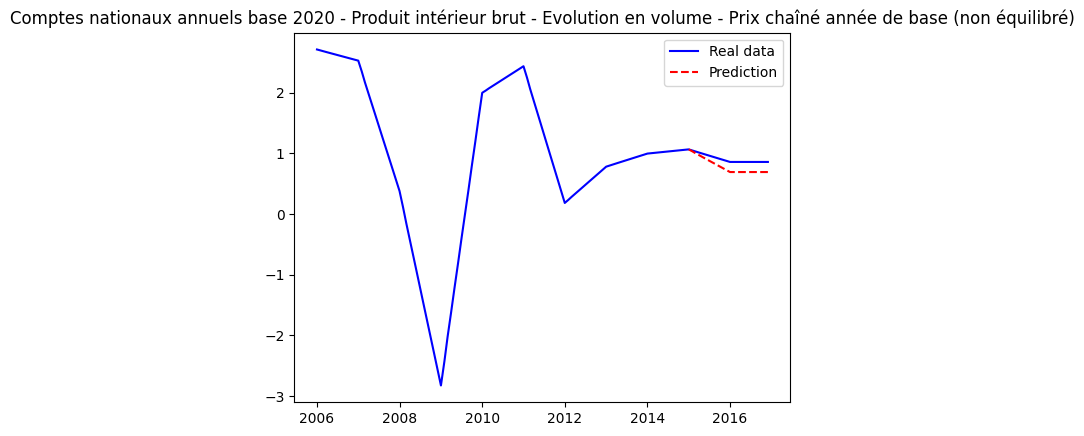

In [147]:
# Inverse transform the prediction and the real data
prediction_data = next(data_processor.inverse_transform([table_state_pred.copy()])) # inverse_transform accepts a list of states
real_data = next(data_processor.inverse_transform([table_state.copy()]))

# And now let's visualize the table
interpolated_prediction = DataUtils.interpolate_missing_values(prediction_data.data.copy())
interpolated_real_data = DataUtils.interpolate_missing_values(real_data.data.copy())

lookback_window = 120
train_cutoff_idx = data_processor.cutoff_idx

plt.plot(real_data.dates[train_cutoff_idx - lookback_window:],
         interpolated_real_data[train_cutoff_idx - lookback_window:, column_id],
         label="Real data", color='blue')
plt.plot(prediction_data.dates[train_cutoff_idx-12:], interpolated_prediction[train_cutoff_idx-12:, column_id],
         label="Prediction", color='red',linestyle="--")

plt.title(real_data.col_to_name[column_id])
plt.legend()
plt.show()

In [148]:
print(column_to_name[column_id])
print("Predicted value:", prediction_data.data[train_cutoff, column_id])
print("Real value:", real_data.data[train_cutoff, column_id])

Comptes nationaux annuels base 2020 - Produit intérieur brut - Evolution en volume - Prix chaîné année de base (non équilibré)
Predicted value: 0.6934117
Real value: 0.86


<div class="alert alert-block alert-success">
<b>Success:</b> You have successfully predicted the future!
</div>

If the prediction looks weird, look up the fitted residuals and the fitted trend. Trend removal still has some issues with exponentials. If the residuals are too small, this indicates that the trend removal was not successful. If the residuals are too big, this indicates that the trend fitting was not succesfull.

If the prediction is not going in the right direction, be mindful that **the training only focuses on column 13 of CNA-2020-PIB**, and other tables/columns are considered as additional tasks.

2025-01-28 01:27:22,608 - DataProvider - INFO - Streamed 39 elements from INSEE
Transformed 39 tables
First 3 table names: ['CHOMAGE-TRIM-NATIONAL', 'CLIMAT-AFFAIRES', 'CNA-2020-CONSO-MEN']
Table name: CNA-2020-PIB 
Column name: Comptes nationaux annuels base 2020 - Importations de biens et de services - Total des secteurs institutionnels - Total des produits (nouvelle nomenclature) - Contribution à l'évolution du produit intérieur brut en volume
2025-01-28 01:27:22,613 - DataProcessor - INFO - Obtaining trends data...
2025-01-28 01:27:22,641 - DataProcessor - INFO - Obtaining raw data...


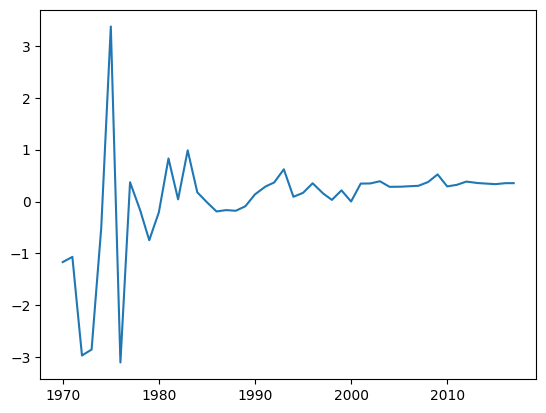

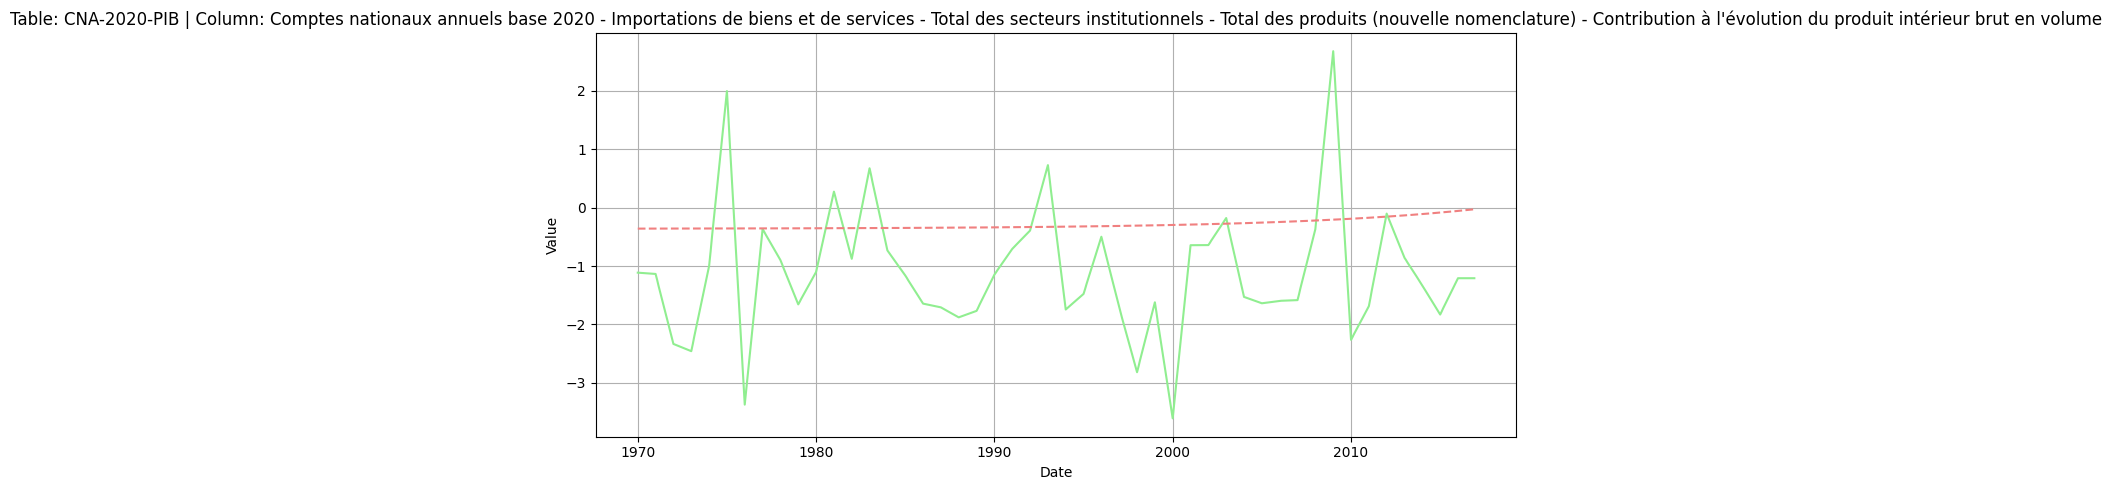

In [96]:
import random
from src.dl_framework.data_pipeline.data_utils import DataUtils

# We can transform the data by iterating over the DataProcessor's transform_from_provider method.
all_states = [state for state in data_processor.transform_from_provider()]
print(f"Transformed {len(all_states)} tables")
print(f"First 3 table names: {[state.table_name for state in all_states[:3]]}")
# Let's visualize the data
sample_state = all_states[9]
table_name = sample_state.table_name
dates = sample_state.dates
data = sample_state.data
column_to_name = sample_state.col_to_name

interpolated_data = DataUtils.interpolate_missing_values(data.copy())
sample_column = 12

print(f"Table name: {table_name} \nColumn name: {column_to_name[sample_column]}")
_ = plt.plot(dates, interpolated_data[:, sample_column])

# Visualize the trend that was used to fit this data
data_processor.plot_trends(processor_id="trend", table_name=table_name, columns=[sample_column], show=True)